# Kaggle Competition Intel & MobileODT Cervical Cancer Screening
I'll be creating a custom CNN using Keras on top of TensorFlow. The data has already been extracted/split and placed into a numpy archive file. Please see Kaggle-Cervical-Cancer-TensorFlow-Data-Extraction.ipynb for information on that process.

In [1]:
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
def SummaryGraphs(hist):
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [3]:
def Submission(mod, img_names, test_imgs):
    #Create Prediction File(.csv)
    test_predictions = mod.predict(test_imgs, batch_size=32, verbose=0)
    test_data = np.column_stack((img_names,test_predictions))
    dfPreds = pd.DataFrame(data=test_data,columns=['image_name','Type_1','Type_2','Type_3'])
    dfPreds.to_csv('submission_1.csv', index=False)

In [4]:
def QuickModel(learning_rate, opt_momentum, opt_decay, dropout):
    #Quick Keras Model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Dropout(dropout))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=learning_rate, momentum=opt_momentum, decay=opt_decay),
                  metrics=['accuracy']
                 )
    return model

In [17]:
def Train(learning_rate, momentum, decay, dropout, epochs, batch_size, slice_size, xtrain, ytrain, xval, yval, logging=0, graph=False):
    #Model
    model = QuickModel(learning_rate, momentum, decay, dropout)

    #Fit Model and save results to history for graphing later.
    history = model.fit(xtrain[:slice_size], ytrain[:slice_size],
              batch_size=batch_size,
              epochs=epochs,
              verbose=logging,
              validation_data=(xval[:slice_size], yval[:slice_size]))
    if graph == True:
        SummaryGraphs(history)
    return model

In [6]:
#Extract Data for training and testing from the .npz file.
with np.load('data_arrays.npz') as data:
    xtr = data['arr_0']
    ytr = data['arr_1']
    xvl = data['arr_2']
    yvl = data['arr_3']
    xts = data['arr_4']
    yts = data['arr_5']

# Sanity Checks
Reference: [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck)

### 1) Look for correct loss at chance performance.
   * Diffuse Probability = 0.33 for each class (3 classes).
   * Softmax => -ln(correct class) = -ln(0.33) = 1.10866 => Estimated Loss at start of training.
   * Set Regularization(dropout) to zero.
   * Initialize hyperparameters as small values.

In [12]:
Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.0, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

Train on 6101 samples, validate on 1526 samples
Epoch 1/1
6101/6101 [==============================] - 24s - loss: 1.1186 - acc: 0.3006 - val_loss: 1.1210 - val_acc: 0.2837


   * As we can see the inital model training loss is pretty close to what we expect.

### 2) As a second sanity check, increasing the regularization strength should increase the loss.

   * I'll increase the dropout rate which means we should see the loss increase from above.

In [13]:
Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.5, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

Train on 6101 samples, validate on 1526 samples
Epoch 1/1
6101/6101 [==============================] - 29s - loss: 1.1313 - acc: 0.3255 - val_loss: 1.0991 - val_acc: 0.3014


   * We can see that the training loss increased from 1.1186 to 1.1313 with a dropout of 0.5

### 3) Overfit a tiny subset of data.
   * If I can't reach a loss of zero, then there is a problem.
   * Set the regularization(dropout) to zero.

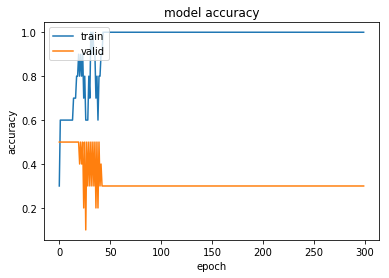

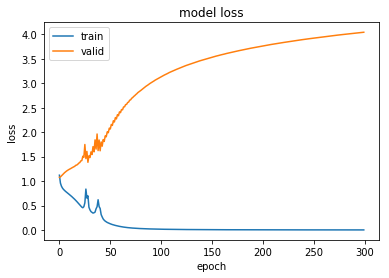

In [15]:
Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.0, epochs=300, 
      batch_size=128, slice_size=10, xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

* As we can see in the "model loss" graph, the training loss has gone to zero. Thus, I was able to overfit the model with a small subset of the data.

# Training
* I will now begin to experiment with hyperparameters during training to determine the best solution for this particular model. 

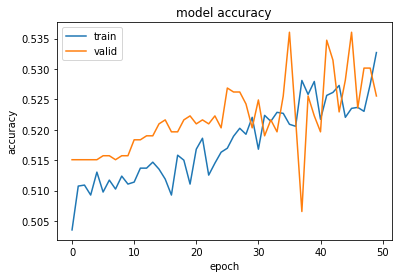

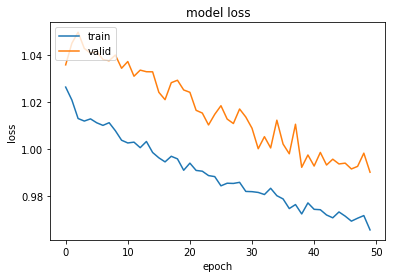

In [16]:
model = Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

It looks like we still have some to gain from this model. I'm going to leave everything the same except for learning rate and see how it performs. I will increase the learning rate.

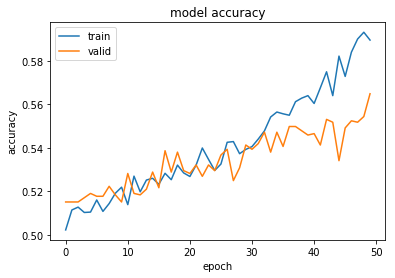

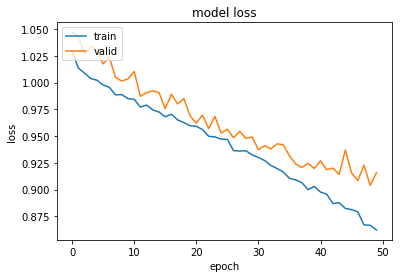

In [18]:
model = Train(learning_rate=0.05, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

The validation and training accuracy started to drift apart just after 30 epochs. So I'm going to decrease the learning rate back down to 0.01 increase the epochs and give it a little bit of momentum.

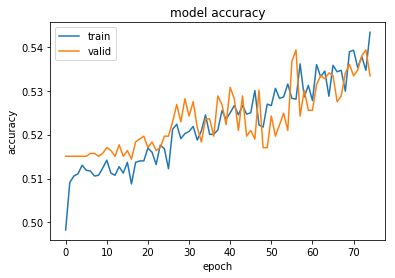

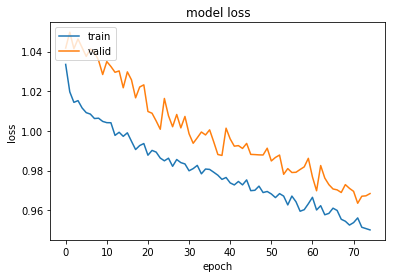

In [19]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=75, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

........

After playing around with hyperparameters I have settled on this model for now.

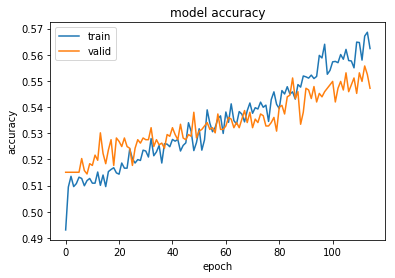

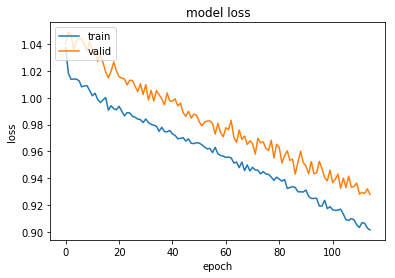

In [32]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=115, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

Below I will create a submission and submit it to Kaggle for official scoring.

In [33]:
Submission(model, yts, xts)

This model scored a 0.91613 on the test data in the Kaggle submission.